In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

### Simple repression

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

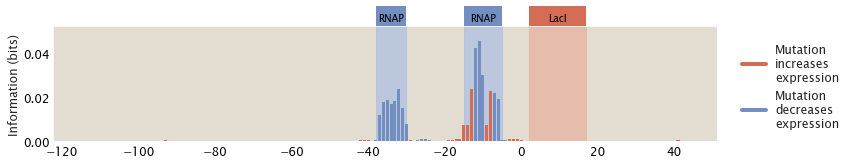

In [6]:
n_NS = len(genome)
n_p = 4600
n_r = 0
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

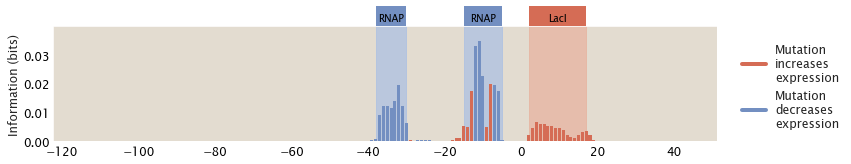

In [7]:
n_NS = len(genome)
n_p = 4600
n_r = 5
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

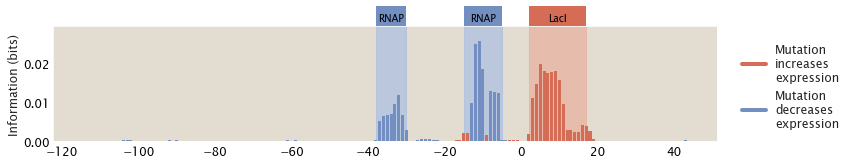

In [8]:
n_NS = len(genome)
n_p = 4600
n_r = 50
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

### Double repression

In [7]:
rep1_site = promoter[(115-70):(115-60)]
rep2_site = promoter[(115-50):(115-40)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [13]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -10, -10
n_p, n_r2 = 4600, 15
l_n_r1 = np.arange(0, 50, 1)
e_int = -10

r1_signal_AND = []
r2_signal_AND = []

for n_r1 in l_n_r1:
    r1 = []
    r2 = []
    for i in range(1):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1.append(np.mean(footprint[(-70+115):(-60+115)]))
        r2.append(np.mean(footprint[(-50+115):(-40+115)]))
    r1_signal_AND.append(np.mean(r1))
    r2_signal_AND.append(np.mean(r2))

In [14]:
r1_signal_OR = []
r2_signal_OR = []

for n_r1 in l_n_r1:
    r1 = []
    r2 = []
    for i in range(1):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1.append(np.mean(footprint[(-70+115):(-60+115)]))
        r2.append(np.mean(footprint[(-50+115):(-40+115)]))
    r1_signal_OR.append(np.mean(r1))
    r2_signal_OR.append(np.mean(r2))

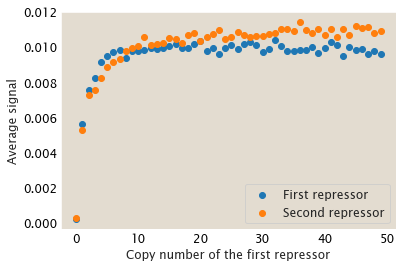

In [19]:
fig, ax = plt.subplots()
ax.scatter(l_n_r1, r1_signal_AND, label='First repressor')
ax.scatter(l_n_r1, r2_signal_AND, label='Second repressor')
ax.set_xlabel('Copy number of the first repressor')
ax.set_ylabel('Average signal')
ax.legend()
plt.show()

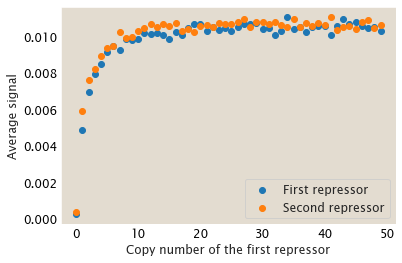

In [27]:
fig, ax = plt.subplots()
ax.scatter(l_n_r1, r1_signal_OR, label='First repressor')
ax.scatter(l_n_r1, r2_signal_OR, label='Second repressor')
ax.set_xlabel('Copy number of the first repressor')
ax.set_ylabel('Average signal')
ax.legend()
plt.show()

In [23]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -7
n_p, n_r2 = 4600, 15

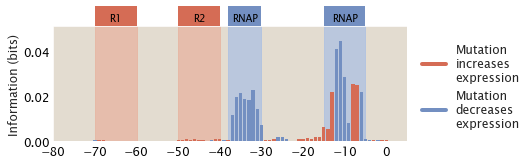

In [24]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35)

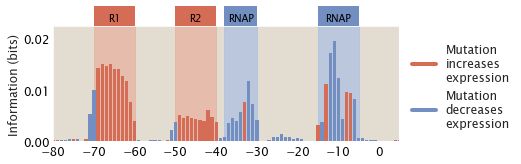

In [25]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35)

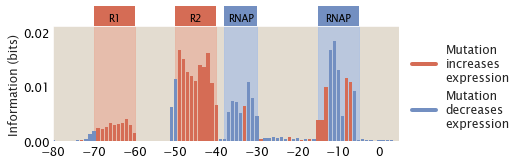

In [26]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35)

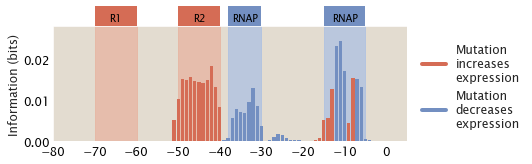

In [24]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35)

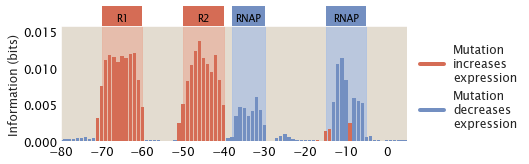

In [25]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35)    

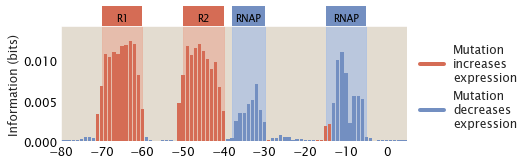

In [26]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -60, 'R', 'R1'), (-50, -40, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35) 

### Double activation

In [7]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

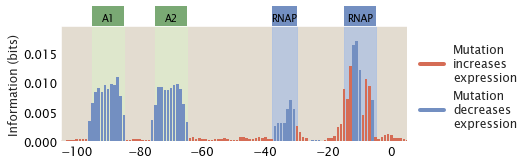

In [16]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a1, n_a2 = 4600, 50, 50

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35)

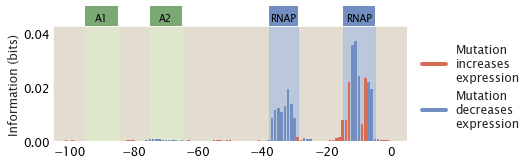

In [17]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a1, n_a2 = 4600, 0, 50

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=100)

region_params = [(-38, -29, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../../manuscript/figures/plots/fig5/doubleact_knockout_AND.png')

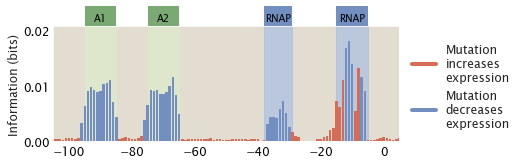

In [18]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 50, 50

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=100)

region_params = [(-38, -29, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35)

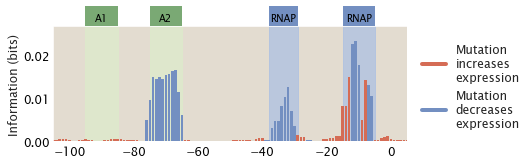

In [19]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 0, 50

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=100)

region_params = [(-38, -29, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-105, 5), fig_width=8, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../../manuscript/figures/plots/fig5/doubleact_knockout_OR.png')

In [20]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a2 = 4600, 50
l_n_a1 = np.arange(0, 50, 2)

list_fc_AND = []
for n_a1 in l_n_a1:
    df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=10**6)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    list_fc_AND.append(fc)

In [21]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a2 = 4600, 50
l_n_a1 = np.arange(0, 50, 2)

list_fc_OR = []
for n_a1 in l_n_a1:
    df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=10**6)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    list_fc_OR.append(fc)

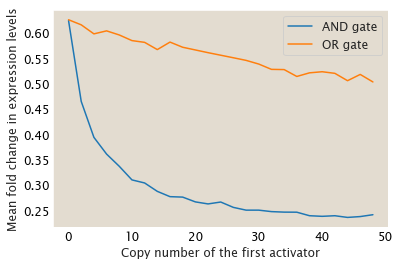

In [22]:
fig, ax = plt.subplots()
ax.plot(l_n_r1, list_fc_AND, label='AND gate')
ax.plot(l_n_r1, list_fc_OR, label='OR gate')
ax.set_xlabel('Copy number of the first activator')
ax.set_ylabel('Mean fold change in expression levels')
ax.legend()
plt.show()

In [9]:
n_NS = len(genome)
ep_wt = -2
ea1_wt, ea2_wt = -7, -7
e_int_pa1, e_int_pa2 = -3, -3
n_p, n_a1, n_a2 = 4600, 50, 50
l_e_int_a1a2 = np.arange(-20, 10, 1)

list_fc_AND2 = []
for e_int_a1a2 in l_e_int_a1a2:
    df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=10**6)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    list_fc_AND2.append(fc)

In [28]:
e_int_pa1, e_int_pa2 = -7, -7
list_fc_AND3 = []
for e_int_a1a2 in l_e_int_a1a2:
    df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=10**6)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    list_fc_AND3.append(fc)

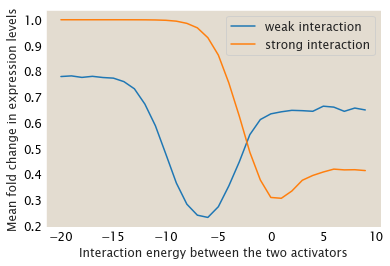

In [29]:
fig, ax = plt.subplots()
ax.plot(l_e_int_a1a2, list_fc_AND2, label='weak interaction')
ax.plot(l_e_int_a1a2, list_fc_AND3, label='strong interaction')
ax.set_xlabel('Interaction energy between the two activators')
ax.set_ylabel('Mean fold change in expression levels')
ax.legend()
plt.show()